In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [154]:
sn = {}
sn_iso = {}
num_list = [0, 100, 200, 300, 400, 649]
for num in num_list:
    sn[num] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2_MHG0.18_Rcut10/lvl4/output', 
                             num, combineFiles=True)
    sn_iso[num] = arepo.Snapshot(basepath + 'runs/MW3iso_fg0.7_MHG0.25_RC9/lvl4/output', num,
                                    combineFiles=True)

Exception: could not detect backend for file '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/runs/MW3iso_fg0.7_MHG0.25_RC9/lvl4/output', snapshot 649, filenum None. Specify file format or check file name.

In [140]:
@njit
def _MC_inner_loop(ParentIDs, ParticleIDs):
    key = np.full(ParentIDs.shape, -1)
    
    ilist = np.arange(len(ParentIDs))
    jlist = np.arange(len(ParticleIDs))
    
    ilist = ilist[np.argsort(ParentIDs)]
    jlist = jlist[np.argsort(ParticleIDs)]
    
    i_ = j_ = 0
    
    while i_ < len(ilist):
        if ParentIDs[ilist[i_]] == ParticleIDs[jlist[j_]]:
            key[ilist[i_]] = jlist[j_]
            i_ += 1
        else:
            j_ += 1
    
    return key

def extract_MC_info(sn0, sn):
    ParentIDs = sn.part5.ParentID
    TracerIDs = sn.part5.TracerID
    
    # Get standard quantities
    if sn.NumPart_Total[4] > 0:
        ParticleIDs = np.concatenate((sn.part0.ParticleIDs, sn.part4.ParticleIDs))
        Coordinates = np.concatenate((sn.part0.Coordinates, sn.part4.Coordinates))
        Velocities = np.concatenate((sn.part0.Velocities, sn.part4.Velocities))
        Masses = np.concatenate((sn.part0.Masses, sn.part4.Masses))
        PartType = np.concatenate((np.full(sn.NumPart_Total[0], 0), np.full(sn.NumPart_Total[4], 4)))
    else:
        ParticleIDs = sn.part0.ParticleIDs
        Coordinates = sn.part0.Coordinates
        Velocities = sn.part0.Velocities
        Masses = sn.part0.Masses
        PartType = np.full(sn.NumPart_Total[0], 0)
    
    # Get initial membership based on metallicity
    MW_Disk = 10.**(-0.3) * 0.0127
    MW_CGM = 10.**(-1.3) * 0.0127
    GSE_Disk = 10.**(-1.2) * 0.0127
    GSE_CGM = 10.**(-1.7) * 0.0127
    
    PartMembership0 = np.full(sn0.NumPart_Total[0], -1)
    
    in_MW_Disk = np.abs(sn0.part0.GFM_Metallicity - MW_Disk) < 1e-8
    in_MW_CGM = np.abs(sn0.part0.GFM_Metallicity - MW_CGM) < 1e-8
    in_GSE_Disk = np.abs(sn0.part0.GFM_Metallicity - GSE_Disk) < 1e-8
    in_GSE_CGM = np.abs(sn0.part0.GFM_Metallicity - GSE_CGM) < 1e-8
    
    PartMembership0[in_MW_Disk] = 0
    PartMembership0[in_MW_CGM] = 1
    PartMembership0[in_GSE_Disk] = 2
    PartMembership0[in_GSE_CGM] = 3
    
    if np.any(PartMembership0 < 0):
        return -1
    
    key = _MC_inner_loop(ParentIDs, ParticleIDs)
    key0 = _MC_inner_loop(sn0.part5.ParentID, sn0.part0.ParticleIDs)
    if np.any(key < 0) or np.any(key0 < 0):
        return -1
    
    MCMembership0 = PartMembership0[key0]
    key0sn = _MC_inner_loop(TracerIDs, sn0.part5.TracerID)
    MCMembershipsn = MCMembership0[key0sn]
    
    MC_Prop = {}
    MC_Prop['Coordinates'] = Coordinates[key]
    MC_Prop['Velocities']  = Velocities[key]
    MC_Prop['Masses']      = Masses[key]
    MC_Prop['PartType']    = PartType[key]
    MC_Prop['Membership']  = MCMembershipsn
    
    return MC_Prop
    

In [159]:
MC_Prop = extract_MC_info(sn[0], sn[649])
MC_Prop_iso = extract_MC_info(sn_iso[0], sn_iso[400])

In [142]:
MC_Prop['Membership'][100]

1

In [143]:
i = 1694
print(np.where(MC_Prop['Membership']==3)[0])
print(MC_Prop['Membership'][i])
print(sn[100].part5.TracerID[i])
PartID0 = sn[0].part5.ParentID[np.where(sn[0].part5.TracerID == sn[100].part5.TracerID[i])[0][0]]
print(PartID0)
key = np.where(sn[0].part0.ParticleIDs == PartID0)
print(np.log10(sn[0].part0.GFM_Metallicity/0.0127)[key])

[   1694    2014    2849 ... 3316293 3316628 3317072]
3
927435
231858
[-0.29999998]


## fraction in disk

In [144]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [156]:
name = 'MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4'
COM_fpath = basepath + 'anlys/COM/COM_' + name + '.npy'
COM_file = np.load(COM_fpath, allow_pickle=True).item()

In [160]:
snap = 649
pos = sn[snap].part2.pos.value - COM_file['MW_COM'][snap]
vel = sn[snap].part2.vel.value - COM_file['MW_COMV'][snap]

posMC = MC_Prop['Coordinates'] - COM_file['MW_COM'][snap]
velMC = MC_Prop['Velocities'] - COM_file['MW_COMV'][snap]

ang_mom = COM_file['MW_AngMom'][snap]

angmom_dir = ang_mom/np.linalg.norm(ang_mom)
theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
k = np.cross(ang_mom, np.array([0, 0, 1.]))
k /= np.linalg.norm(k)

pos_rot = rodrigues_formula(k, pos, theta)
vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)

posMC_rot = rodrigues_formula(k, posMC.astype(np.float64), theta)
velMC_rot = rodrigues_formula(k, velMC.astype(np.float64), theta)

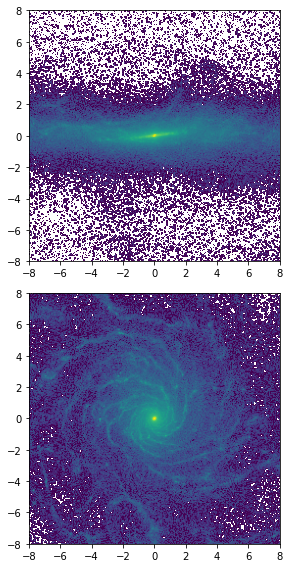

In [161]:
nres = 256
range_xy = [[-8,8], [-8, 8]]
range_xz = [[-8,8], [-8, 8]]

x = posMC_rot[:,0]
y = posMC_rot[:,1]
z = posMC_rot[:,2]


# x = pos[:,0]
# y = pos[:,1]
# z = pos[:,2]

H,   _, _ = np.histogram2d(y, x, bins=(nres, nres), range=range_xy)
Hxz, _, _ = np.histogram2d(y, z, bins=(nres, nres), range=range_xz)

extent_xy = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]
extent_xz = [range_xz[0][0], range_xz[0][1], range_xz[1][0], range_xz[1][1]]

fig, ax = plt.subplots(2, 1, figsize=(4, 8))

ax[0].imshow(Hxz.T, extent=extent_xz, origin='lower', norm=mpl.colors.LogNorm())
# ax[0].scatter(x_center, z_center, c='r', s=1)
ax[0].set_aspect('equal')

ax[1].imshow(H.T, extent=extent_xy, origin='lower', norm=mpl.colors.LogNorm())
# ax[1].scatter(x_center, y_center, c='r', s=1)
ax[1].set_aspect('equal')

fig.tight_layout()
plt.show()

In [162]:
R = np.linalg.norm(posMC_rot[:,:2], axis=1)
z = posMC_rot[:,2]
key = np.logical_and(R < 10, np.abs(z) < 3)

mass = MC_Prop['Masses']
memb = MC_Prop['Membership']

mass_in_memb = []

for memb_id in [0, 1, 2, 3]:
    keymemb = np.logical_and(key, memb==memb_id)
    mass_in_memb.append(np.sum(mass[keymemb]))

totmass = np.sum(mass_in_memb)
for memb_id in [0, 1, 2, 3]:
    print(memb_id, mass_in_memb[memb_id]/totmass)

0 0.5569094
1 0.39404058
2 0.04356752
3 0.0054825614


In [153]:
center = np.array([sn_iso[400].BoxSize, sn_iso[400].BoxSize, sn_iso[400].BoxSize])/2.
posMC_iso = MC_Prop_iso['Coordinates'] - center

R = np.linalg.norm(posMC_iso[:,:2], axis=1)
z = posMC_iso[:,2]
key = np.logical_and(R < 10, np.abs(z) < 3)

mass = MC_Prop_iso['Masses']
memb = MC_Prop_iso['Membership']

mass_in_memb = []

for memb_id in [0, 1, 2, 3]:
    keymemb = np.logical_and(key, memb==memb_id)
    mass_in_memb.append(np.sum(mass[keymemb]))

totmass = np.sum(mass_in_memb)
for memb_id in [0, 1, 2, 3]:
    print(memb_id, mass_in_memb[memb_id]/totmass)

0 0.6991236
1 0.30087638
2 0.0
3 0.0


### GSE gas fraction

In [4]:
def get_disk_prop(name):

    Time = []
    MassInDisk = []
    MetalDisk = []
    for i in [0, 1, 2, 3]:
        MassInDisk.append([])

    for snap in tqdm(np.arange(0, 800, 10)):
        fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
        if not os.path.isfile(fname):
            continue
        
        f = h5.File(fname, mode='r')
    
        Time.append(f['Header'].attrs['Time'])
    
        pos = f['PartType5/RotatedCoordinates'][:]
        mass = f['PartType5/Masses'][:]
        memb = f['PartType5/Membership'][:]
        ptype = f['PartType5/PartType'][:]
        massmetal = f['PartType5/GFM_Metallicity'][:] * mass
        R = np.linalg.norm(pos[:,:2], axis=1)
        z = pos[:,2]
    
        in_disk = np.logical_and(R < 10, np.abs(z) < 3)
        gas_in_disk = np.logical_and(in_disk, ptype==0)
    
        metal_in_disk = np.sum(massmetal[gas_in_disk])
        mass_in_disk = np.sum(mass[gas_in_disk])
        MetalDisk.append(metal_in_disk/mass_in_disk)
    
        for i in [0, 1, 2, 3]:
            gas_in_disk_i = np.logical_and(memb==i, gas_in_disk)
            MassInDisk[i].append(np.sum(mass[gas_in_disk_i]))
    
        f.close()
    
    for i in [0, 1, 2, 3]:
        MassInDisk[i] = np.array(MassInDisk[i])
    
    return np.array(Time), MassInDisk, np.array(MetalDisk)

In [5]:
name = 'MW3_MHG0.25_GSE2-lvl4'
Time, MassInDisk, MetalDisk = get_disk_prop(name)

nameiso = 'MW3iso_fg0.7_MHG0.25_RC9-lvl4'
Timeiso, MassInDiskio, MetalDiskiso = get_disk_prop(nameiso)

100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


In [ ]:
### TotMass = np.sum(MassInDisk, axis=0)
l0 = plt.plot(Time, MassInDisk[0]/TotMass, label='0')
l1 = plt.plot(Time, MassInDisk[1]/TotMass, label='1')
plt.plot(Time, MassInDisk[2]/TotMass, label='2')
plt.plot(Time, MassInDisk[3]/TotMass, label='3')

print(np.array(MassInDisk)[:,-1]/TotMass[-1])

# TotMassiso = np.sum(MassInDiskiso, axis=0)
# plt.plot(Timeiso, MassInDiskiso[0]/TotMassiso, c=l0[0].get_color(), ls='dashed')
# plt.plot(Timeiso, MassInDiskiso[1]/TotMassiso, c=l1[0].get_color(), ls='dashed')

plt.legend(frameon=False)
plt.xlim(0, None)
plt.ylim(0.001, None)
# plt.yscale('log')

In [221]:
arr = np.random.rand(10)

In [222]:
arr[None]

array([[0.35280556, 0.74782081, 0.15843465, 0.82893749, 0.57981806,
        0.08448861, 0.95331452, 0.85504333, 0.83247417, 0.24761845]])

In [230]:
sn[400].part2.pos.value.shape

(108150, 3)

In [268]:
name = 'MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4'
snap = 640

fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
f = h5.File(fname, mode='r')

In [269]:
pos = f['PartType5/RotatedCoordinates'][:]
mass = f['PartType5/Masses'][:]
memb = f['PartType5/Membership'][:]
ptype = f['PartType5/PartType'][:]
R = np.linalg.norm(pos[:,:2], axis=1)
z = pos[:,2]

from_GSE_disk = memb == 2
r = np.linalg.norm(pos, axis=1)

GSE_in_10 = np.logical_and(r < 10, memb==2)
print(np.sum(mass[GSE_in_10]))

0.3199023


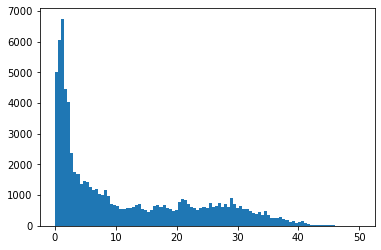

In [263]:
plt.hist(r[from_GSE_disk], bins=np.linspace(0, 50, 100));

In [270]:
name = 'MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4'
snap = 678

fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
f = h5.File(fname, mode='r')

In [271]:
pos = f['PartType5/RotatedCoordinates'][:]
mass = f['PartType5/Masses'][:]
memb = f['PartType5/Membership'][:]
ptype = f['PartType5/PartType'][:]
R = np.linalg.norm(pos[:,:2], axis=1)
z = pos[:,2]

from_GSE_disk = memb == 2
r = np.linalg.norm(pos, axis=1)

GSE_in_10 = np.logical_and(r < 10, memb==2)
print(np.sum(mass[GSE_in_10]))

0.35622674


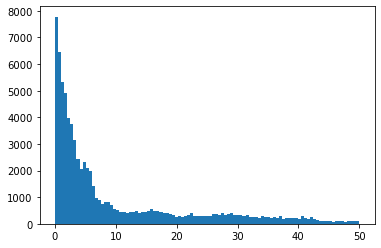

In [266]:
plt.hist(r[from_GSE_disk], bins=np.linspace(0, 50, 100));

In [277]:
fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(100).zfill(3)+'.h5'
f = h5.File(fname, mode='r')

In [278]:
f['PartType5'].keys()

<KeysViewHDF5 ['Coordinates', 'Masses', 'Membership', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>

(-0.2, 0.1)

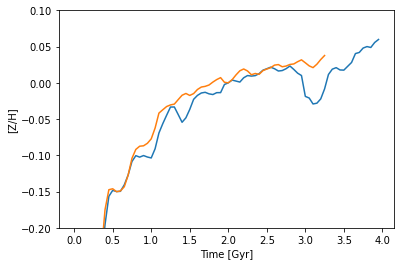

In [36]:
plt.plot(Time, np.log10(MetalDisk/MetalDisk[40]))
plt.plot(Timeiso, np.log10((MetalDiskiso/MetalDiskiso[40])))
plt.xlabel('Time [Gyr]')
plt.ylabel('[Z/H]')
plt.ylim(-0.2, 0.1)

In [37]:
def get_rough_metallicity(MW_mass, MW_metal_frac, GSE_mass, GSE_metal_frac):
    MW_metal = MW_mass * MW_metal_frac
    GSE_metal = GSE_mass * GSE_metal_frac
    
    return (MW_metal + GSE_metal) / (MW_mass + GSE_mass)
    

In [75]:
metal_time = get_rough_metallicity(MassInDisk[0]+MassInDisk[1], 10.**(-0.3)*0.0127, MassInDisk[2], 10.**(-1.2)*0.0127)

-0.333619


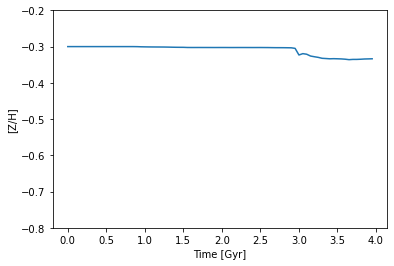

In [77]:
plt.plot(Time, np.log10(metal_time/0.0127))
plt.ylim(-0.8, -0.2)
plt.xlabel('Time [Gyr]')
plt.ylabel('[Z/H]')
print(np.log10(metal_time/0.0127)[-1]) 

In [93]:
def get_metal_profile(snap, name):

    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')

    pos = f['PartType5/RotatedCoordinates'][:]
    ptype = f['PartType5/PartType'][:]
    mass = f['PartType5/Masses'][:]
    memb = f['PartType5/Membership'][:]
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]

    Rmin = 0.
    dR = 0.5

    metallicity = []
    aveR = []

    while Rmin < 15:
        in_annulus = np.logical_and(R > Rmin, R < Rmin+dR)
        in_annulus = np.logical_and(in_annulus, np.abs(z) < 3)
        gas_in_annulus = np.logical_and(ptype==0, in_annulus)
    
        memb0_key = np.logical_and(gas_in_annulus, memb==0)
        memb1_key = np.logical_and(gas_in_annulus, memb==1)
        memb2_key = np.logical_and(gas_in_annulus, memb==2)
        memb3_key = np.logical_and(gas_in_annulus, memb==3)
    
        mass0 = np.sum(mass[memb0_key])
        mass1 = np.sum(mass[memb1_key])
        mass2 = np.sum(mass[memb2_key])
        mass3 = np.sum(mass[memb3_key])
    
        metal_annulus = get_rough_metallicity(mass0 + mass1, 10.**(-0.3)*0.0127, mass2, 10.**(-1.2)*0.0127)
    
        metallicity.append(metal_annulus)
        aveR.append(np.mean(R[gas_in_annulus]))

        Rmin += dR
    
    metallicity = np.array(metallicity)
    aveR = np.array(aveR)
    time = f['Header'].attrs['Time']

    f.close()
    
    return time, aveR, metallicity

In [95]:
name = 'MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4'

Time = []
aveR = []
Metallicity = []

for snap in tqdm(np.arange(0, 800, 10)):
    t_, R_, metal_ = get_metal_profile(snap, name)
    
    Time.append(t_)
    aveR.append(R_)
    Metallicity.append(metal_)

Time = np.array(Time)
aveR = np.array(aveR)
Metallicity = np.array(Metallicity)

100%|██████████| 80/80 [01:54<00:00,  1.43s/it]


In [96]:
aveR.shape

(80, 30)

(0.0, 4.0)

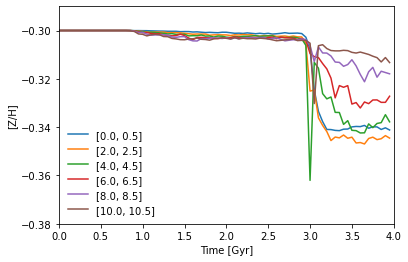

In [117]:
i = 0
Rbin = [0.5*i, 0.5*(i+1)]
plt.plot(Time, np.log10(Metallicity[:,i]/0.0127), label=str(Rbin))

i = 4
Rbin = [0.5*i, 0.5*(i+1)]
plt.plot(Time, np.log10(Metallicity[:,i]/0.0127), label=str(Rbin))

i = 8
Rbin = [0.5*i, 0.5*(i+1)]
plt.plot(Time, np.log10(Metallicity[:,i]/0.0127), label=str(Rbin))

i = 12
Rbin = [0.5*i, 0.5*(i+1)]
plt.plot(Time, np.log10(Metallicity[:,i]/0.0127), label=str(Rbin))

i = 16
Rbin = [0.5*i, 0.5*(i+1)]
plt.plot(Time, np.log10(Metallicity[:,i]/0.0127), label=str(Rbin))

i = 20
Rbin = [0.5*i, 0.5*(i+1)]
plt.plot(Time, np.log10(Metallicity[:,i]/0.0127), label=str(Rbin))

plt.legend(frameon=False)
plt.ylim(-0.38, -0.29)

plt.xlabel('Time [Gyr]')
plt.ylabel('[Z/H]')

# plt.xlim(2.8, 3.2)
plt.xlim(0, 4)

Text(0, 0.5, '[Z/H]')

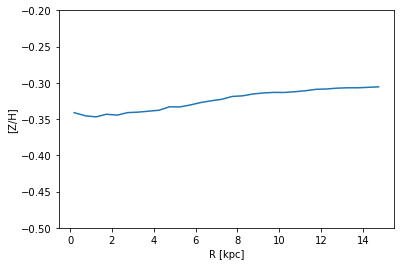

In [118]:
plt.plot(aveR[-1], np.log10(Metallicity[-1]/0.0127))
plt.ylim(-0.5, -0.2)
plt.xlabel('R [kpc]')
plt.ylabel('[Z/H]')

In [129]:
m = get_rough_metallicity(1, 10.**(-0.3)*0.0127, 1.0, 10.**(-10)*0.0127)
print(np.log10(m/0.0127))

-0.6010299955773281


### Total metallicity in disk